In [1]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from nsepy import get_history as gh
import datetime as dt
start = dt.datetime(2020,11,1)
end = dt.datetime(2021,11,1)
stock='BHARTIARTL'
df = gh(symbol=stock,start=start,end=end)
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2020-11-02,BHARTIARTL,EQ,433.75,435.0,460.00,435.00,455.55,457.40,451.11,28174600,1.270977e+15,262756,9622899,0.3415
2020-11-03,BHARTIARTL,EQ,457.40,458.0,460.70,447.45,454.90,454.60,454.62,16036760,7.290606e+14,162571,5662537,0.3531
2020-11-04,BHARTIARTL,EQ,454.60,453.0,455.55,447.15,451.50,453.05,451.71,10003680,4.518785e+14,98671,3323113,0.3322
2020-11-05,BHARTIARTL,EQ,453.05,457.0,461.90,452.60,458.00,457.30,457.50,9234395,4.224738e+14,109959,3414270,0.3697
2020-11-06,BHARTIARTL,EQ,457.30,457.0,460.35,448.75,450.25,449.90,453.18,11970462,5.424776e+14,130841,5122085,0.4279


In [2]:
sf=df.index
cf=df['Close'].values
pf=pd.DataFrame()
pf['Date']=sf
pf['Close']=cf
pf.head()
df=pf
df.head()

,Date,Close
0,2020-11-02,457.40
1,2020-11-03,454.60
2,2020-11-04,453.05
3,2020-11-05,457.30
4,2020-11-06,449.90


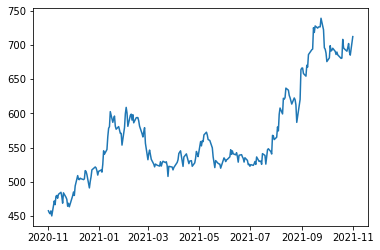

In [3]:
import matplotlib.pyplot as plt
df['Date'] = pd.to_datetime(df['Date'])
df.set_axis(df['Date'], inplace=True)
plt.plot(df['Close'])

In [4]:
close_data = df['Close'].values
close_data = close_data.reshape((-1,1))
split_percent = 0.80
split = int(split_percent*len(close_data))
close_train = close_data[:split]
close_test = close_data[split:]
date_train = df['Date'][:split]
date_test = df['Date'][split:]
print(len(close_train),len(close_test))

198 50


In [5]:
look_back = 15
train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()
lossini = 10000000000000
turn=10
mm=[]
ans=50

while(turn>0):
    turn=turn-1
    mm.append(Sequential())
    mm[9-turn].add(
    LSTM(10,
         activation='relu',
         input_shape=(look_back, 1))
    )
    mm[9-turn].add(Dense(1))
    mm[9-turn].compile(optimizer='adam', loss='mse')
    num_epochs = 100
    mm[9-turn].fit(train_generator, epochs=num_epochs, verbose=1, callbacks=[history])
    print(len(history.losses))
    mino=float(history.losses[len(history.losses)-1])
    print(mino)
    if(mino<lossini):
        ans=9-turn
    lossini=min(mino,lossini)
    print(lossini,turn)
model=mm[ans]

Epoch 1/100
10/10 [==============================] - 2s 9ms/step - loss: 31459.7754
Epoch 2/100
10/10 [==============================] - 0s 10ms/step - loss: 19603.1367
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 10004.4316
Epoch 4/100
10/10 [==============================] - 0s 7ms/step - loss: 6409.0034
Epoch 5/100
10/10 [==============================] - 0s 8ms/step - loss: 2347.0657
Epoch 6/100
10/10 [==============================] - 0s 8ms/step - loss: 1743.2021
Epoch 7/100
10/10 [==============================] - 0s 8ms/step - loss: 1596.8993
Epoch 8/100
10/10 [==============================] - 0s 9ms/step - loss: 1823.7510
Epoch 9/100
10/10 [==============================] - 0s 9ms/step - loss: 1837.8181
Epoch 10/100
10/10 [==============================] - 0s 8ms/step - loss: 1645.5198
Epoch 11/100
10/10 [==============================] - 0s 8ms/step - loss: 1660.5248
Epoch 12/100
10/10 [==============================] - 0s 9ms/step - loss: 1764.09

In [7]:
prediction = model.predict(test_generator)
import plotly.graph_objects as go
close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))
print(len(close_test))
trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = stock+" Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()
print(len(prediction),len(date_test))

50


35 50


In [8]:
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)
forecast

array([712.5       , 716.25323486, 709.43615723, 703.32434082,
       699.16809082, 695.62280273, 692.50231934, 689.61157227,
       686.80963135, 684.08526611, 681.42156982, 678.80566406,
       676.22589111, 673.67437744, 671.1552124 , 668.66705322,
       666.1940918 , 663.73712158, 661.30267334, 658.89385986,
       656.5111084 , 654.1541748 , 651.82263184, 649.51611328,
       647.23419189, 644.97650146, 642.74273682, 640.53259277,
       638.34576416, 636.1819458 , 634.04083252])

In [9]:
trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
trace4 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode='lines',
    name = 'Forecasted'
)
fig = go.Figure(data=[trace1, trace2, trace3,trace4], layout=layout)
fig.show()